In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
# using Optim
# using ForwardDiff
using DelimitedFiles
using LineSearches

In [3]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [4]:
function envelope(t)
    if t < 2
        return sin(pi/4*t)^2
    elseif 28 < t <= 30
        return cos(pi/4*(t-28))^2
    else
        return 1
    end
end

h_times = LinRange(0,30,200+2)[2:end-1]
dt = h_times[1]
function pulse(p, t)
    out = 0
    w_sum = 0
    for (i, ht) in enumerate(h_times)
        w = exp( - 10/(2*dt^2) * (t - ht)^2)
        out += p[i] * w
        w_sum += w
    end
    envelope(t)*out/w_sum
end

# function envelope(t)
#     if t < 0.1
#         return sin(pi/2*t/0.1)^2
#     elseif 30-0.1 < t <= 30
#         return cos(pi/2*(t-0.1)/0.1)^2
#     else
#         return 1
#     end
# end
# h_times = LinRange(0,30,200+2)[2:end-1]
# dt = h_times[2] - h_times[1]
# function pulse(p,t)
#     out = 0
#     w_start = exp( - 5/(2*dt^2) * (t - 0)^2)
#     w_end = exp( - 5/(2*dt^2) * (t - 30)^2)
#     w_sum = w_start + w_end
#     for (i, ht) in enumerate(h_times)
#         w = exp( - 5/(2*dt^2) * (t - ht)^2)
#         out += p[i] * w
#         w_sum += w
#     end
#     envelope(t)*out/w_sum
# end

pulse (generic function with 1 method)

In [36]:
# p = readdlm("..\\..\\JuliaStuff\\params.txt")[end,:] ;
# p2 = readdlm("..\\..\\JuliaStuff\\params.txt")[end,:] ;
p = readdlm("tmp_paramsmm_r0.txt")[end,:]
times = LinRange(0,30,5000)
;

In [37]:
ψs = eigvecs(Matrix(KinPot12 + Potential3))

function H!(du, u, p, t)
    du[:] = -im .* ((KinPot12 + Potential3 + pulse(p,t) .* chargecoupling) * u)
    # du[:] = -im .* ((KinPot12 + DRAGalpha(t) .* Potential3 + DRAGpulse(0.9778,t) .* chargecoupling) * u)
end

forward_prob = ODEProblem(H!, ψs[:,1:2], (0.0, 30.0), p)
sol = solve(forward_prob, p=p, saveat=times, reltol=1e-10, abstol=1e-10) ;

In [38]:
occs = zeros(Float64,length(sol.t),289,2)

for (i, t) in enumerate(sol.t)
    # Es, ψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(ψs'*sol.u[i])
end

In [39]:
colors = ["#0F956F" "#BA2936" 1 4 "#000852"]

1×5 Matrix{Any}:
 "#0F956F"  "#BA2936"  1  4  "#000852"

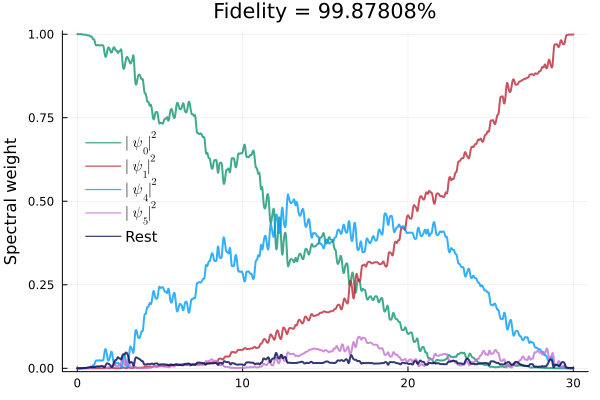

In [40]:
using LaTeXStrings
Occs_plot = plot(sol.t,
     [occs[:,[1,2,5,6],1], abs.(1 .- sum(occs[:,[1,2,5,6],1],dims=2))],
    #  yaxis=:log10,
     ylim=(-0.01,1.01),
     linewidth=2,
     alpha=0.8,
     # yticks=[10^i for i=-5.:0],#(append!([i*10^j for i = 1:9 for j = -5.:-1],[1]),tmp)
     # xlabel=L"$t$ [ns]",
     ylabel="Spectral weight",
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" L"|\psi_4|^2" L"|\psi_5|^2" "Rest"],
     legend=:left,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=10,
     color=colors,
     title = "Fidelity = "*string((1 - 0.5*(2-occs[end,1,2] - occs[end,2,1]))*100)[1:8]*"%",
)

In [41]:
0.5*sum(abs.(1 .- sum(occs[:,[1,2,5,6],1:2],dims=2)))*times[2]/30, 0.071/0.02, 1-0.02/0.0713438

(0.015218207534017964, 3.55, 0.7196673011530084)

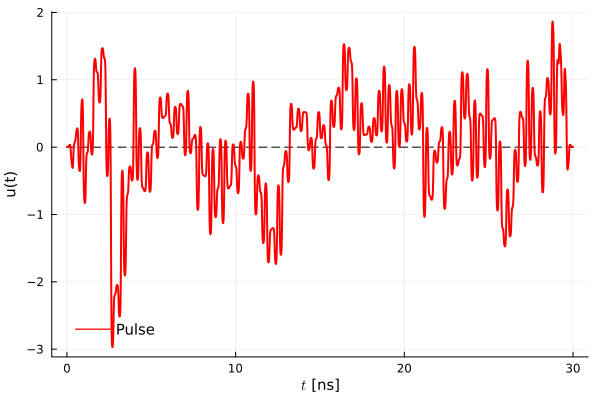

In [44]:
pulse_plot = plot([0,30],[0,0],ls=:dash,color=:black,label=nothing)
plot!(times,[[pulse(p,t) for t in times]],#,[pulse(p2,t) for t in times]],
                    linewidth=2,
                    color=[:red :black],
                    # ylim=(-2.5,2.5),
                    ls =:solid,
                    label="Pulse",
                    ylabel="u(t)",
                    legend=:bottomleft,
                    background_color_legend = nothing,
                    foreground_color_legend = nothing,
                    legendfontsize=10,
                    labelfontsize=10,
                    ticklabelfontsize=20,
                    # axiscolor=:red,
                    xlabel=L"$t$ [ns]")

In [56]:
using Plots.PlotMeasures
plt = plot(Occs_plot,pulse_plot,layout=(2,1),size=(1000,500),bottom_margin=20px,right_margin=20px,left_margin=20px)
# savefig(plt,"ConstAlphaSwapGate200pf2.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\NoAlpha\\ConstAlphaSwapGate200pf2.pdf"

In [13]:
Es = real.(eigvals(Matrix(KinPot12 + Potential3))) ;
(Es .- Es')[1:9,1:9]

9×9 Matrix{Float64}:
  0.0      -1.54389  -11.8201   -13.2305   …  -22.4753   -24.2161   -27.234
  1.54389   0.0      -10.2762   -11.6866      -20.9315   -22.6722   -25.6901
 11.8201   10.2762     0.0       -1.41042     -10.6553   -12.3961   -15.414
 13.2305   11.6866     1.41042    0.0          -9.24487  -10.9856   -14.0035
 17.7584   16.2145     5.93833    4.52791      -4.71696   -6.45774   -9.47562
 19.8723   18.3284     8.0522     6.64178  …   -2.60309   -4.34387   -7.36175
 22.4753   20.9315    10.6553     9.24487       0.0       -1.74077   -4.75866
 24.2161   22.6722    12.3961    10.9856        1.74077    0.0       -3.01789
 27.234    25.6901    15.414     14.0035        4.75866    3.01789    0.0

In [14]:
# sortperm(reshape((Es .- Es')[1:9,1:9],81))[46:end]
# sort(reshape((Es .- Es')[1:9,1:9],81))[46:end]
w = (Es .- Es')#[8,9]
;

In [217]:
reshape((Es .- Es')[1:9,1:9],81)[54], w[9,6]

(7.361753591701756, 7.361753591701756)

0.7507744545672016  $\omega_{76}$2.5538698211803372  $\omega_{54}$9.684873958408831  $\omega_{63}$7.801753591701757  $\omega_{85}$

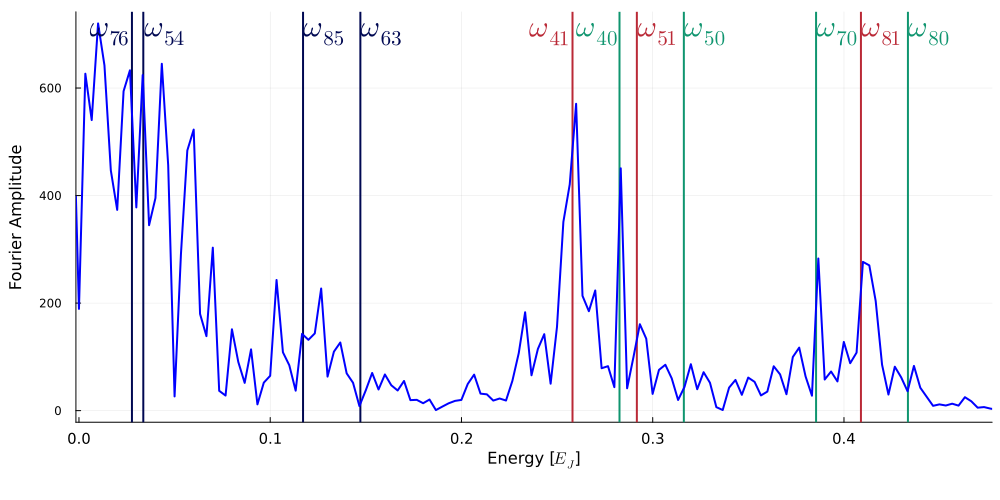

In [51]:
# vlines = [1.54389, 5.93833, 9.24487,16.2145, 17.7584, 19.8723, 22.4753, 24.2161, 25.6901]
# vlines = [17.7584 18.3284 2.1138698211803373 16.2145]
vlines = reshape((Es .- Es')[1:9,1:9],81)
# vlines0toN =(Es .- Es')[2:end,1]
vlines0toN = [w[5,1] w[6,1] w[8,1] w[9,1]]
# vlines1toN =(Es .- Es')[3:end,2]
vlines1toN = [w[5,2] w[6,2] w[9,2]]
vlinesExtra = [w[8,7] w[6,5] w[7,4] w[9,6]]
labels = [L"  $\omega_{40}$"
          L"  $\omega_{50}$" 
          L"  $\omega_{70}$" 
          L"  $\omega_{80}$"
          L"  $\omega_{41}$"#"\n"*
          L"  $\omega_{51}$"
          L"  $\omega_{81}$"
          L"  $\omega_{76}$"
          L"  $\omega_{54}$" 
          L"  $\omega_{63}$"
          L"  $\omega_{85}$"]

using FFTW

function pulse2(t)
    if t > 30
        return 0
    end
    return pulse(p,t)
end

times = LinRange(0,30,5000)
Ts = times[2] - times[1]
F = fft([pulse(p,t) for t in times]) |> fftshift
# F = fft([sin(t) for t in times]) |> fftshift
freqs = fftfreq(length(times), 1/Ts) |> fftshift

# plot(vlines,seriestype=:vline,color=:green,lw=2,xticks=(sort(reshape((Es .- Es')[1:9,1:9],81))[46:end],sortperm(reshape((Es .- Es')[1:9,1:9],81))[46:end]),xrotation=90,bottom_margin=60px)
EJscale = 2pi*E_J_GHz
xticks = ((EJscale .* [0 0.1 0.2 0.3 0.4 0.5])[1,:], [0 0.1 0.2 0.3 0.4 0.5])
pltF = plot(vlines0toN,seriestype=:vline,color="#0F956F",lw=2,label=nothing,ylabel="Fourier Amplitude",xlabel=L"Energy [$E_J$]",xticks=xticks)
plot!(vlines1toN,seriestype=:vline,color="#BA2936",lw=2,label=nothing)
plot!(vlinesExtra,seriestype=:vline,color="#000852",lw=2,label=nothing) 

plot!((freqs*2*pi),abs.(F),xlim=(-0.1,30),size=(1000,500),lw=2,color=:blue, #(1000,500)
# xticks = (cat([0],vlines0toN,vlines1toN,[15],vlinesExtra,[30],dims=2)[1,:], labels),
label=nothing,xtickfontsize=10,bottom_margin=40px,right_margin=0px,left_margin=20px)
# plot!([-1],seriestype=:vline,color="#0F956F",lw=2,label=L"$\omega_{N0}$",legendfontsize=20)
shift = [-0.9 0.4 0.4 0.4].* 1.1
for (xpos, text) in zip(vlines0toN + shift, labels[1:4])
    # print(xpos, text)
    annotate!(xpos,700,text,annotationcolor="#0F956F",annotationfontsize=20)
end
shift = [-0.9 0.4 0.4] .* 1.1
for (xpos, text) in zip(vlines1toN + shift, labels[5:7])
    # print(xpos, text)
    annotate!(xpos,700,text,annotationcolor="#BA2936",annotationfontsize=20)
end
shift = [-0.9 0.4 0.4 0.4].* 1.1
for (xpos, text) in zip(vlinesExtra + shift, labels[8:end])
    print(xpos, text)
    annotate!(xpos,700,text,annotationcolor="#000852",annotationfontsize=20)
end
# for (xpos, text) in zip(cat(vlines0toN,vlines1toN,vlinesExtra,dims=2)[1,:], labels)
#     # print(xpos, text)
#     annotate!(xpos,700,text)
# end
# for (xpos, text) in zip(cat(vlines0toN,vlines1toN,vlinesExtra,dims=2)[1,:], labels)
#     # print(xpos, text)
#     annotate!(xpos,700,text)
# end


pltF
# savefig(pltF,"ConstAlphaFourier200p2.pdf")

In [543]:
vlinesExtra

1×4 Matrix{Float64}:
 1.74077  2.11387  9.24487  7.36175

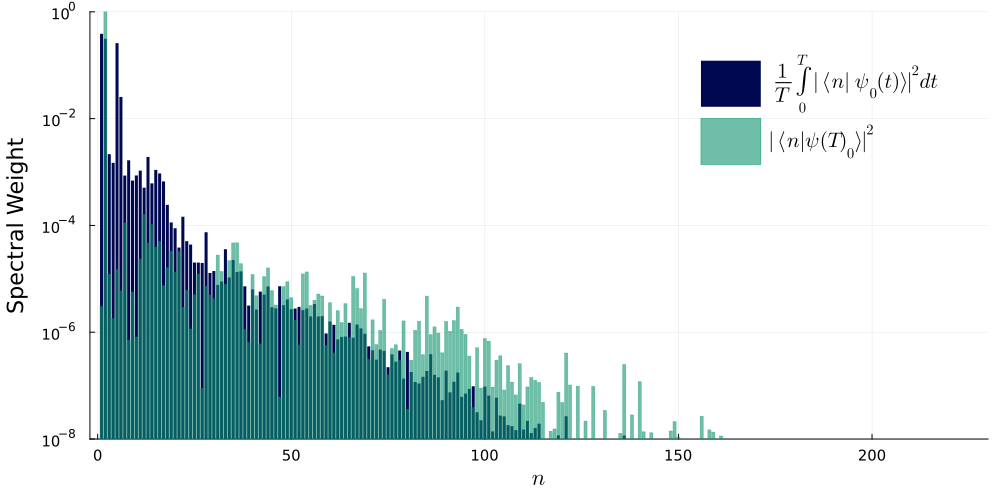

In [52]:
pltS = bar([sum(occs,dims=1)[1,1:200,1]*times[2]/30,occs[end,1:289,1]],
yscale=:log10,
size=(1000,500),
ylim=(1e-8,1),
alpha=[1 0.6],
color=["#000852" "#0F956F"],
alignment=:center,
ylabel="Spectral Weight",
xlabel=L"$n$",
labelfontsize=15,
bottom_margin=20px,
left_margin=20px,
xlim=(-2,230),
tickfontsize=10,
label=[L"$\frac{1}{T}\int_0^T|\langle n|\psi_0(t)\rangle|^2dt$" L"$|\langle n|\psi(T)_0\rangle|^2$"],
background_color_legend = nothing,
foreground_color_legend = nothing,
linecolor=["white" "#0F956F"],
width=[0.0 0.5],
legendfontsize=14)
# savefig(pltS,"ConstAlphaSpectralWeight200p2.pdf")

In [54]:
plt = plot(pltF,pltS,layout=(2,1),size=(1000,500),bottom_margin=20px,right_margin=20px,left_margin=20px)
# savefig(plt,"ConstAlphaFS200pf2.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\NoAlpha\\ConstAlphaFS200pf2.pdf"